### GPU Setup

In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.6.0
Default GPU Device: /device:GPU:0
Num GPUs Available:  1


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17599468378374460262,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9898950656
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13097121780313075452
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"]

### Import Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, UpSampling2D, AveragePooling2D,ZeroPadding2D,Convolution2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
from IPython.display import SVG, Image
import cv2
import utils

### Malware Classes

In [4]:
class_names = []
for types in os.listdir("ecg_cropped/"):
    print(str(len(os.listdir("ecg_cropped/"+ types)))+" "+ types+' images')
    class_names.append(types)

class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

250 COVID images
233 HB images
239 MI images
250 Normal images
172 PMI images
1 testing images
1 training images
1 validation images


### Data Processing & Image Data Generator

Image Size = 80 * 80 

Randomly horizontally flips the images

Color Mode = RGB

Batch Size = 32

In [5]:
img_size=(70,70)
batch_size = 32
datagen_train=ImageDataGenerator(horizontal_flip=True)
train_generator=datagen_train.flow_from_directory("ecg_cropped/training/ecg_cropped",
target_size=img_size,
batch_size=batch_size,
class_mode='categorical',
color_mode ="grayscale",
shuffle=True)

datagen_validation=ImageDataGenerator(horizontal_flip=True)
validation_generator=datagen_validation.flow_from_directory("ecg_cropped/validation/ecg_cropped",
target_size=img_size,
batch_size=batch_size,
class_mode='categorical',
color_mode ="grayscale",
shuffle=True)

datagen_test=ImageDataGenerator(horizontal_flip=True)
test_generator=datagen_test.flow_from_directory("ecg_cropped/testing/ecg_cropped",
target_size=img_size,
batch_size=batch_size,
class_mode='categorical',
color_mode ="grayscale",
shuffle=True)

Found 1081 images belonging to 5 classes.
Found 212 images belonging to 5 classes.
Found 228 images belonging to 5 classes.


### CNN Architecture

13 Convolutional Layers, added Batch Normalization after each one.
Activation = ReLU.
Dropout = 15%.


In [6]:
##malware

detection = Sequential()
detection.add(Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(70, 70, 1)))
detection.add(BatchNormalization())
detection.add(MaxPooling2D((2, 2)))


detection.add(Conv2D(16, (3, 3), activation='relu',  padding='same'))
detection.add(BatchNormalization())
detection.add(MaxPooling2D((2, 2)))


detection.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
detection.add(BatchNormalization())
detection.add(MaxPooling2D((2, 2)))


detection.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
detection.add(BatchNormalization())
detection.add(MaxPooling2D((2, 2)))


detection.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
detection.add(BatchNormalization())
detection.add(MaxPooling2D((2, 2)))
detection.add(Dropout(0.15))

detection.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
detection.add(BatchNormalization())
detection.add(MaxPooling2D((2, 2)))
detection.add(Dropout(0.15))

detection.add(Flatten())
detection.add(Dense(512, activation='relu'))
detection.add(Dense(5, activation='softmax'))
optimum= Adam(learning_rate=0.0001)


def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

detection.compile(loss='categorical_crossentropy', optimizer=optimum, metrics=['accuracy',recall,precision,tf.keras.metrics.AUC(curve="ROC"),tf.keras.metrics.FalsePositives(),tf.keras.metrics.TruePositives(),tf.keras.metrics.FalseNegatives(),tf.keras.metrics.TrueNegatives(),tf.keras.metrics.SensitivityAtSpecificity(0.5)])

In [7]:
detection.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 70, 70, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 70, 70, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 35, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 35, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 32)        4

### Model Visualization

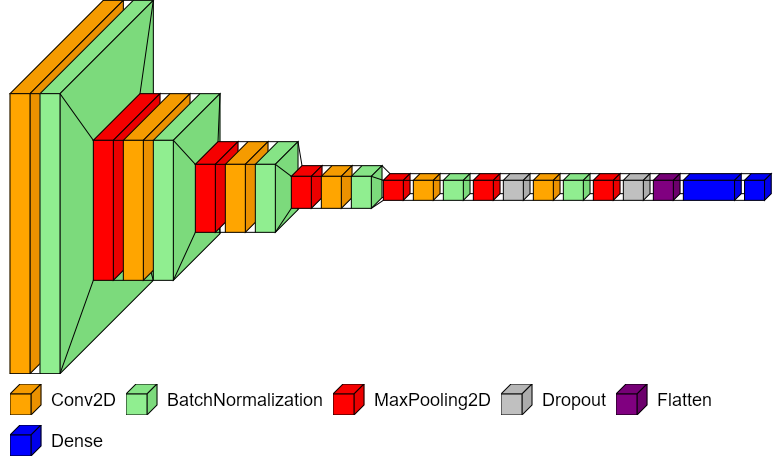

In [8]:
from PIL import ImageFont
from collections import defaultdict

font = ImageFont.truetype("arial.ttf", 18) 

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[Dropout]['fill'] = 'silver'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Dense]['fill'] = 'blue'
color_map[Flatten]['fill'] = 'purple'
color_map[BatchNormalization]['fill'] = 'lightgreen'

import visualkeras
visualkeras.layered_view(detection, legend=True,font=font,color_map=color_map)

Number of epochs =35

In [9]:
%%time
batch_size = 32


ephocs=70
                    

steps_per_epoch=train_generator.n//train_generator.batch_size
steps_per_epoch
validation_steps=validation_generator.n//validation_generator.batch_size
validation_steps
mod = detection.fit(x=train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=ephocs,
                    validation_data=validation_generator,
                    validation_steps=validation_steps
                    )


Epoch 1/70
33/33 [==============================] - 7s 107ms/step - loss: 1.5631 - accuracy: 0.3356 - recall: 0.0994 - precision: 0.4608 - auc: 0.6409 - false_positives: 85.0000 - true_positives: 105.0000 - false_negatives: 944.0000 - true_negatives: 4111.0000 - sensitivity_at_specificity: 0.6816 - val_loss: 1.8417 - val_accuracy: 0.1875 - val_recall: 0.0052 - val_precision: 0.0556 - val_auc: 0.5430 - val_false_positives: 3.0000 - val_true_positives: 1.0000 - val_false_negatives: 191.0000 - val_true_negatives: 765.0000 - val_sensitivity_at_specificity: 0.5625
Epoch 2/70
33/33 [==============================] - 3s 89ms/step - loss: 1.0829 - accuracy: 0.5891 - recall: 0.3192 - precision: 0.7603 - auc: 0.8562 - false_positives: 107.0000 - true_positives: 334.0000 - false_negatives: 715.0000 - true_negatives: 4089.0000 - sensitivity_at_specificity: 0.9228 - val_loss: 1.8143 - val_accuracy: 0.2240 - val_recall: 0.0052 - val_precision: 0.0556 - val_auc: 0.5472 - val_false_positives: 19.0000 

### Model Evaluation

In [10]:
detection.save('ecg-class.h5')

detection.evaluate(test_generator,verbose=1)

8/8 [==============================] - 1s 102ms/step - loss: 0.0598 - accuracy: 0.9825 - recall: 0.9531 - precision: 0.9570 - auc: 0.9996 - false_positives: 4.0000 - true_positives: 223.0000 - false_negatives: 5.0000 - true_negatives: 908.0000 - sensitivity_at_specificity: 1.0000


[0.059766728430986404,
 0.9824561476707458,
 0.953125,
 0.95703125,
 0.9996225237846375,
 4.0,
 223.0,
 5.0,
 908.0,
 1.0]

### Loss vs Epoch Graph - Train and Validation

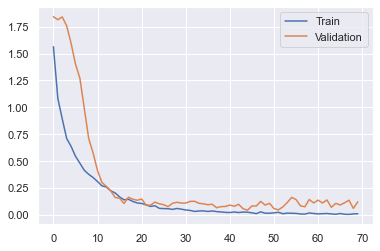

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.plot(mod.history['loss'], label='Train')
plt.plot(mod.history['val_loss'], label='Validation')

plt.legend()

plt.show()
plt.savefig('LossVal_loss_nonaugmented')


### Accuracy vs Epoch Graph - Train and Validation

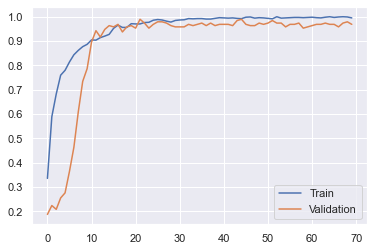

<Figure size 432x288 with 0 Axes>

In [12]:
plt.plot(mod.history['accuracy'], label='Train')
plt.plot(mod.history['val_accuracy'], label='Validation')
plt.legend()

plt.show()
plt.savefig('AccVal_acc_nonaugmented')
